In [103]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf

### EDA

Pull in data.

In [88]:
data = pd.read_csv('data/avocado.csv')
data = data.drop(columns=['Unnamed: 0'])
data = data[data['region'] != 'TotalUS']
data = data.rename(columns={'4046' : 'Small Hass', '4225' : 'Large Hass', '4770' : 'XL Hass'})
data.columns = data.columns.str.replace(' ', '_')
data['Date'] = pd.to_datetime(data['Date'])
data = data.copy()
data.head()

,Date,AveragePrice,Total_Volume,Small_Hass,Large_Hass,XL_Hass,Total_Bags,Small_Bags,Large_Bags,XLarge_Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Descriptive statistics.

In [89]:
round(data.describe(), 2)

,Date,AveragePrice,Total_Volume,Small_Hass,Large_Hass,XL_Hass,Total_Bags,Small_Bags,Large_Bags,XLarge_Bags,year
count,17911,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00,17911.00
mean,2016-08-13 23:30:10.351180800,1.41,539258.69,183807.41,188223.11,14551.23,152675.73,116202.87,34505.69,1967.17,2016.15
min,2015-01-04 00:00:00,0.44,84.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015.00
25%,2015-10-25 00:00:00,1.10,10571.02,819.66,2909.61,0.00,4905.20,2700.34,113.00,0.00,2015.00
50%,2016-08-14 00:00:00,1.37,100154.13,7824.43,26701.99,164.23,37551.02,24530.62,2459.22,0.00,2016.00
75%,2017-06-04 00:00:00,1.67,400176.68,101488.82,131755.22,5736.74,103691.60,79282.59,19421.71,106.76,2017.00
max,2018-03-25 00:00:00,3.25,11274749.11,5160896.68,5402444.45,804558.25,4145406.70,3403581.49,2838239.39,131300.76,2018.00
std,NaN,0.40,1224331.91,515105.86,451985.65,48817.54,364599.23,278759.60,113947.74,8186.40,0.94


Below is a plot of average daily volume by region. It appears that the larger the region (e.g. "West"), the more volume there is. This makes sense for obvious reasons. I believe that region will be key in trying to predict prices.

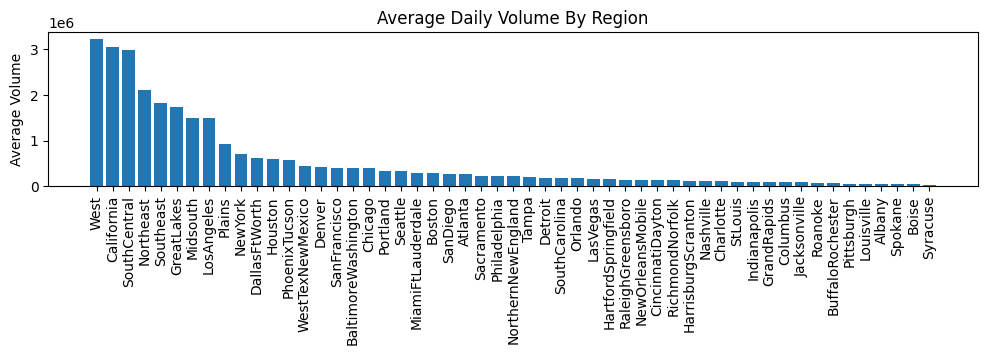

In [90]:
vol = data.drop(columns=['Date', 'type']).groupby('region').mean()['Total_Volume'].sort_values(ascending=False)

plt.figure(figsize=[12,2])
plt.bar(vol.index, vol)
plt.xticks(rotation=90)
plt.title('Average Daily Volume By Region')
plt.ylabel('Average Volume')
plt.show()

Below is a plot of average daily price by region. It appears that the farther you get from the southern US, the higher prices are.

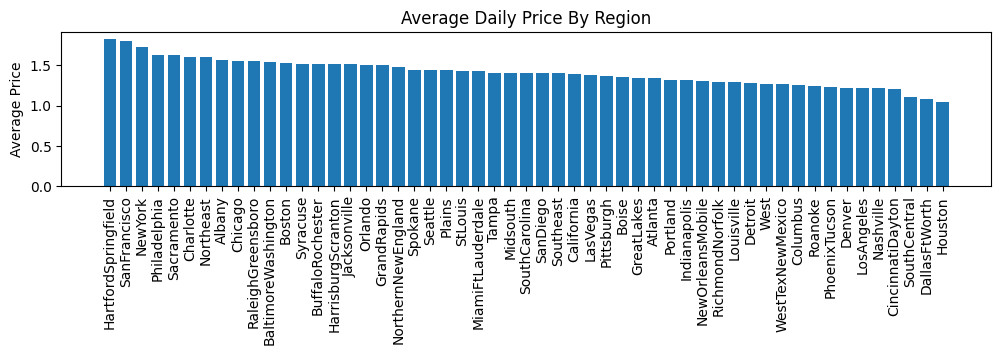

In [91]:
price = data.drop(columns=['Date', 'type']).groupby('region').mean()['AveragePrice'].sort_values(ascending=False)

plt.figure(figsize=[12,2])
plt.bar(price.index, price)
plt.xticks(rotation=90)
plt.title('Average Daily Price By Region')
plt.ylabel('Average Price')
plt.show()

Below is a plot of average daily prices across the entire US. We see a spike in the fall of 2016 and the fall of 2017, however other than that there is not a glaringly obvious cyclicality.

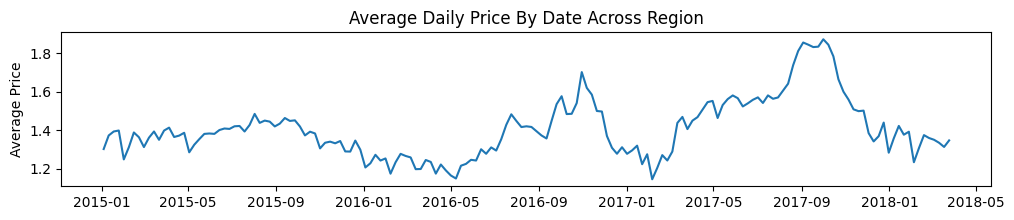

In [94]:
date_group = data.drop(columns=['region', 'type']).groupby('Date').mean()

plt.figure(figsize=[12,2])
plt.plot(date_group['AveragePrice'])
plt.title('Average Daily Price By Date Across Region')
plt.ylabel('Average Price')
plt.show()

Below we plot all of the features, grouping by date. The data seem to show correlation with one another.

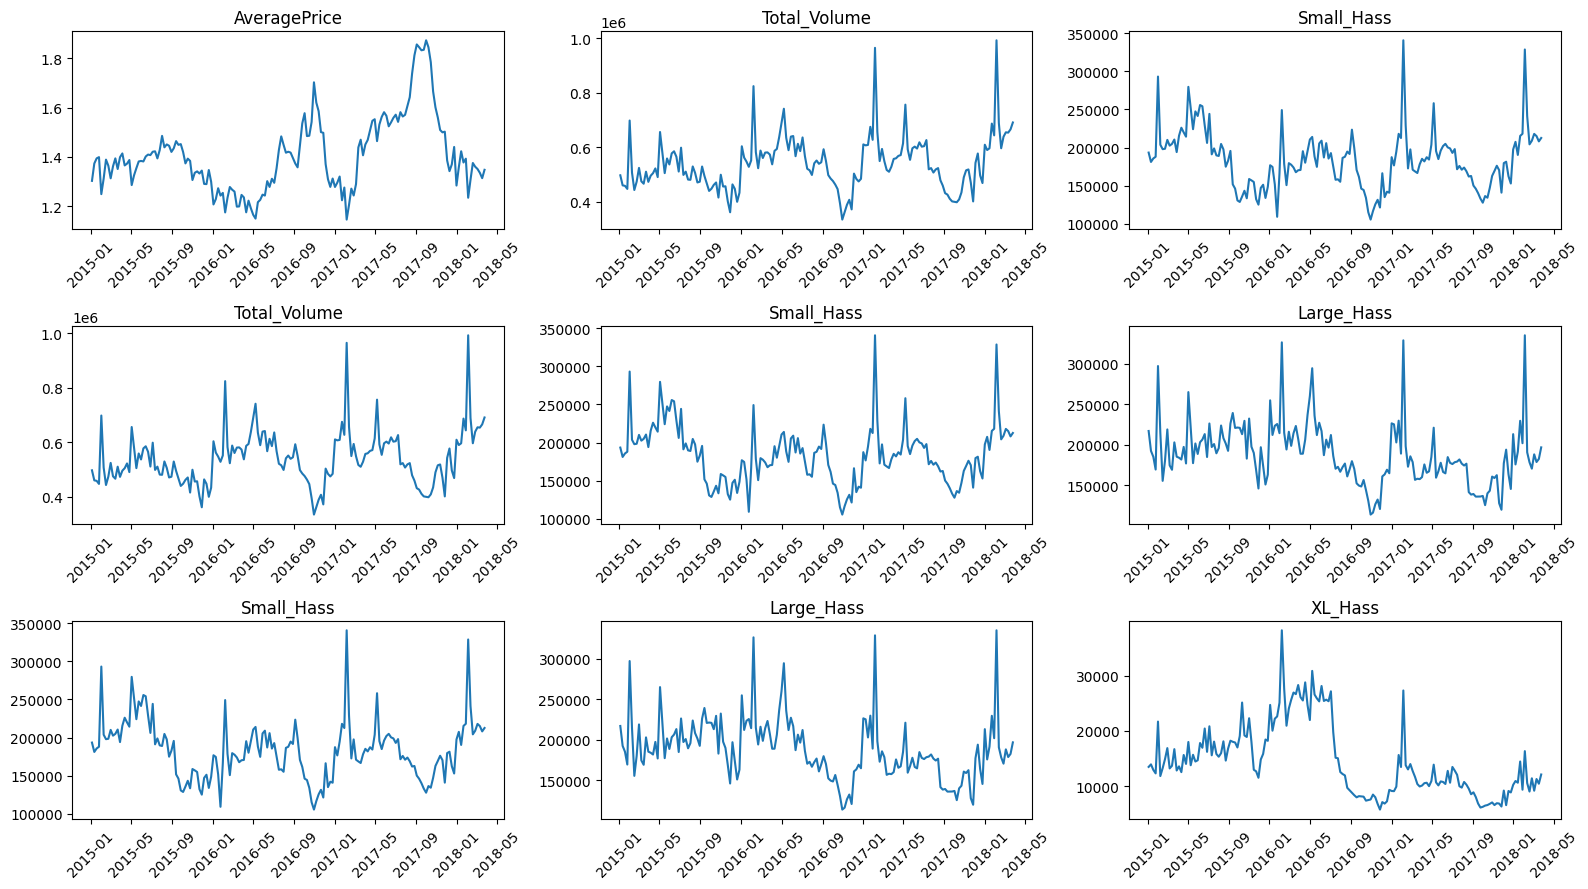

In [95]:
fig, axs = plt.subplots(3, 3, figsize=[16,9])

for i in range(3):
    for j in range(3):
        col = date_group.iloc[:,i + j]
        
        axs[i][j].plot(col)
        
        axs[i][j].set_title(col.name)
        axs[i][j].tick_params(axis='x', labelrotation=45)
        
fig.tight_layout()
plt.show()

Below is a table of correlations.

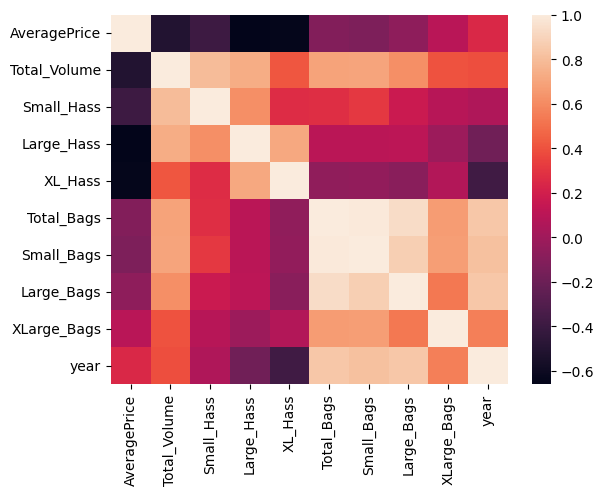

In [107]:
corr = pd.DataFrame(np.corrcoef(date_group.T))
corr.columns = date_group.columns
corr.index = date_group.columns
sns.heatmap(corr)
plt.show()

### Data Cleaning

In [6]:
X = data.drop(columns=['Outcome'])
y = data[['Outcome']]

We will split the data into a training set (60%), a test set (20%), and a validation set (20%).

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=11)

### Model Fitting

We will be using TensorFlow to implement our neural network model. Our model will use one hidden layer with 4 nodes that use a relu activation functions and then an output layer that uses the sigmoid function. We use the sigmoid function in the output layer because we are performing a classification exercise.

In [8]:
def create_model(learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(8,)))
    model.add(tf.keras.layers.Dense(4, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)     # Use .legacy version on M1/M2 Macs
    loss = tf.keras.losses.BinaryCrossentropy()

    model.compile(loss=loss, optimizer=optimizer)

    return model

In [9]:
def process_data(X):
    normalize = tf.keras.layers.Normalization(axis=1)
    normalize.adapt(X)
    X_norm = normalize(X)

    return X_norm

First we need to process our data by normalizing it. To normalize it we take each column of our feature dataframes and apply the following function:

$$ f(x) = \frac {X - \mu}{\sigma} $$

In [10]:
X_train_norm = process_data(X_train)
X_val_norm = process_data(X_val)
X_test_norm = process_data(X_test)

Next, we instantiate an initial model to ensure that our create_model function is working.

In [11]:
tf.keras.utils.set_random_seed(18)
learning_rate = .1
model = create_model(learning_rate)
model.fit(X_train_norm, y_train, epochs=300, batch_size=50)

Epoch 1/300
10/10 [==============================] - 0s 615us/step - loss: 0.5766
Epoch 2/300
10/10 [==============================] - 0s 720us/step - loss: 0.4744
Epoch 3/300
10/10 [==============================] - 0s 606us/step - loss: 0.4277
Epoch 4/300
10/10 [==============================] - 0s 544us/step - loss: 0.4273
Epoch 5/300
10/10 [==============================] - 0s 484us/step - loss: 0.4234
Epoch 6/300
10/10 [==============================] - 0s 645us/step - loss: 0.4234
Epoch 7/300
10/10 [==============================] - 0s 487us/step - loss: 0.4235
Epoch 8/300
10/10 [==============================] - 0s 663us/step - loss: 0.4159
Epoch 9/300
10/10 [==============================] - 0s 576us/step - loss: 0.4187
Epoch 10/300
10/10 [==============================] - 0s 493us/step - loss: 0.4172
Epoch 11/300
10/10 [==============================] - 0s 608us/step - loss: 0.4289
Epoch 12/300
10/10 [==============================] - 0s 489us/step - loss: 0.4083
Epoch 13/300


Here are the different hyperparameter values that we will optimize the model to.

In [12]:
parameters = {'learning_rate' : [.1, .01, .001, .0001],
              'epochs' : [50, 100, 200, 300],
              'batch_size' : [0.0, 0.2, 0.4]
}

We run a grid search to find the best hyperparameters. We will evaluate a model's fit by its accuracy on our validation set.

In [13]:
train_losses = {}
val_losses = {}

total = 1
for i in parameters.values():
    total *= len(i)

print('Models Fitted: %d/%d (%.2f%%)' % (0, total, 0), end='\r')
count = 1
for learning_rate in parameters['learning_rate']:
    for epochs in parameters['epochs']:
        for batch_size in parameters['batch_size']:            
            model = create_model(learning_rate)
            model.fit(X_train_norm,
                      y_train,
                      epochs=epochs,
                      batch_size=int(batch_size * len(X_train_norm)),
                      validation_data=(X_val_norm, y_val),
                      verbose=0)

            train_losses.update({(learning_rate, epochs, batch_size) : model.history.history['loss'][-1]})
            val_losses.update({(learning_rate, epochs, batch_size) : model.history.history['val_loss'][-1]})

            print('Models Trained: %d/%d (%.2f%%)' % (count, total, 100 * count / total), end='\r')
            count += 1

In [14]:
results = pd.DataFrame({'train_loss' : train_losses, 'val_loss' : val_losses})
results = results.reset_index()
results.columns = ['learning_rate', 'epochs', 'batch_size', 'train_score', 'val_score']
results = results.sort_values('val_score', ascending=True)
results.head()

,learning_rate,epochs,batch_size,train_score,val_score
35,0.001,300,0.4,0.436486,0.488261
24,0.001,50,0.0,0.476130,0.490693
32,0.001,200,0.4,0.437596,0.494796
28,0.001,100,0.2,0.479529,0.502583
23,0.010,300,0.4,0.393144,0.509000


In [15]:
print('Our best model has the following parameters')

for key, value in round(results.iloc[0][:3], 3).to_dict().items():
    print(key, '=', value)

Our best model has the following parameters
learning_rate = 0.001
epochs = 300.0
batch_size = 0.4


We have the best hyperparameters from the grid search. In a normal scenario, when our grid search picks a hyperparameter that is on the upper or lower edge of the range that we are testing, we would normally want to re-run the gridsearch with a  We create a fresh model with those hyperparameters and train it on our training data.

In [16]:
model = create_model(results.iloc[0]['learning_rate'])
model.fit(X_train_norm,
          y_train,
          epochs=int(results.iloc[0]['epochs']),
          batch_size=int(results.iloc[0]['batch_size'] * len(X_train_norm)),
          validation_data=(X_val_norm, y_val))

Epoch 1/300
3/3 [==============================] - 0s 24ms/step - loss: 0.9309 - val_loss: 0.8738
Epoch 2/300
3/3 [==============================] - 0s 6ms/step - loss: 0.9237 - val_loss: 0.8673
Epoch 3/300
3/3 [==============================] - 0s 5ms/step - loss: 0.9166 - val_loss: 0.8609
Epoch 4/300
3/3 [==============================] - 0s 7ms/step - loss: 0.9098 - val_loss: 0.8546
Epoch 5/300
3/3 [==============================] - 0s 6ms/step - loss: 0.9033 - val_loss: 0.8485
Epoch 6/300
3/3 [==============================] - 0s 6ms/step - loss: 0.8966 - val_loss: 0.8425
Epoch 7/300
3/3 [==============================] - 0s 6ms/step - loss: 0.8901 - val_loss: 0.8367
Epoch 8/300
3/3 [==============================] - 0s 6ms/step - loss: 0.8839 - val_loss: 0.8309
Epoch 9/300
3/3 [==============================] - 0s 6ms/step - loss: 0.8776 - val_loss: 0.8254
Epoch 10/300
3/3 [==============================] - 0s 6ms/step - loss: 0.8716 - val_loss: 0.8200
Epoch 11/300
3/3 [==========

We visualize the convergence of the model's loss below. We can notice that although the loss of the training set goes down, the loss of the validation set rises. This might point to the idea that the model is being overfit on to the nuances of the training data and is therefore a worse fit on other data sets.

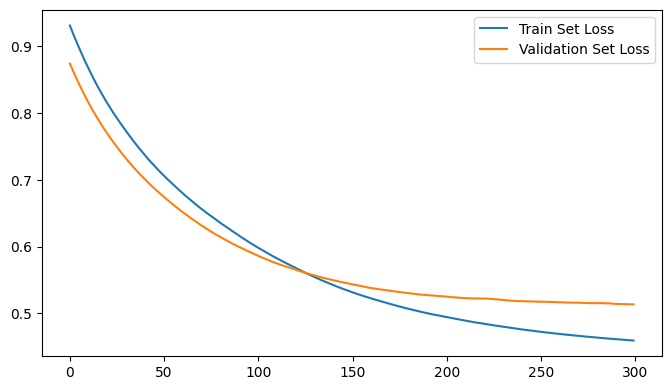

In [17]:
plt.figure(figsize=[8,4.5])
plt.plot(model.history.history['loss'], label='Train Set Loss')
plt.plot(model.history.history['val_loss'], label='Validation Set Loss')
plt.legend()
plt.show()

We will assume that a prediction probability of 0.5 or greater is classified as True and anything else as False.

In [18]:
preds_test = model.predict(X_test_norm)
results_test = pd.DataFrame({'Target' : np.array(y_test).T[0], 'True Prob' : preds_test.T[0], 'False Prob' : 1 - preds_test.T[0]})
results_test['Target'] = results_test['Target'].astype(bool)
results_test['Prediction'] = results_test['True Prob'] >= .5
results_test['Correct'] = results_test['Target'] == results_test['Prediction']
results_test.head()

5/5 [==============================] - 0s 588us/step


,Target,True Prob,False Prob,Prediction,Correct
0,True,0.448031,0.551969,False,False
1,False,0.195154,0.804846,False,True
2,False,0.070700,0.929300,False,True
3,True,0.408690,0.591310,False,False
4,True,0.589113,0.410887,True,True


In [19]:
a = 100 * results_test[results_test['Target'] == True]['Correct'].sum() / len(results_test[results_test['Target'] == True])
print('Guessed Test True Correctly %.2f%%' % a)
b = 100 * results_test[results_test['Target'] == False]['Correct'].sum() / len(results_test[results_test['Target'] == False])
print('Guessed Test False Correctly %.2f%%' % b)
c = 100 * results_test['Correct'].sum() / len(results_test)
print('Guessed Test Correctly %.2f%%' % c)

Guessed Test True Correctly 48.33%
Guessed Test False Correctly 86.17%
Guessed Test Correctly 71.43%


In [20]:
preds_train = model.predict(X_train_norm)
results_train = pd.DataFrame({'Target' : np.array(y_train).T[0], 'True Prob' : preds_train.T[0], 'False Prob' : 1 - preds_train.T[0]})
results_train['Target'] = results_train['Target'].astype(bool)
results_train['Prediction'] = results_train['True Prob'] >= .5
results_train['Correct'] = results_train['Target'] == results_train['Prediction']
results_train.head()

15/15 [==============================] - 0s 741us/step


,Target,True Prob,False Prob,Prediction,Correct
0,True,0.513519,0.486481,True,True
1,False,0.560282,0.439718,True,False
2,False,0.180036,0.819964,False,True
3,False,0.360330,0.639670,False,True
4,True,0.238345,0.761655,False,False


In [21]:
a = 100 * results_train[results_train['Target'] == True]['Correct'].sum() / len(results_train[results_train['Target'] == True])
print('Guessed Train True Correctly %.2f%%' % a)
b = 100 * results_train[results_train['Target'] == False]['Correct'].sum() / len(results_train[results_train['Target'] == False])
print('Guessed Train False Correctly %.2f%%' % b)
c = 100 * results_train['Correct'].sum() / len(results_train)
print('Guessed Train Correctly %.2f%%' % c)

Guessed Train True Correctly 63.58%
Guessed Train False Correctly 87.58%
Guessed Train Correctly 79.13%


We see that our model predicts better on our training data than on our test data, which is expected. However, the model is still able to predict diabetes correctly in +70% of our test instances, which is a reasonable result.

In [22]:
preds_val = model.predict(X_val_norm)
results_val = pd.DataFrame({'Target' : np.array(y_val).T[0], 'True Prob' : preds_val.T[0], 'False Prob' : 1 - preds_val.T[0]})
results_val['Target'] = results_val['Target'].astype(bool)
results_val['Prediction'] = results_val['True Prob'] >= .5
results_val['Correct'] = results_val['Target'] == results_val['Prediction']

5/5 [==============================] - 0s 720us/step


Here we look at the ROC Curve. If our curve was simply a straight diagonal line $(y=x)$, our model would have no predictive power, i.e. when the threshold of predicting a positive result vs. a negative result is raised (remember we picked 0.5) our model's performance improves linearly. But we see that this is not the case for any of our three sets, so our model does have predictive power.

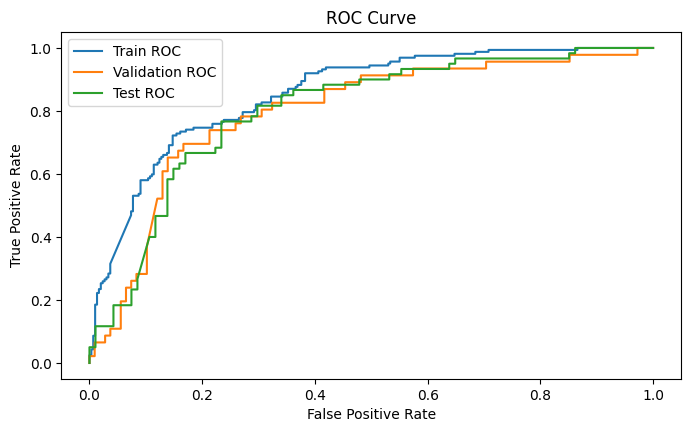

In [23]:
train_roc = roc_curve(results_train['Target'], results_train['True Prob'])
val_roc = roc_curve(results_val['Target'], results_val['True Prob'])
test_roc = roc_curve(results_test['Target'], results_test['True Prob'])

plt.figure(figsize=[8,4.5])
plt.plot(train_roc[0], train_roc[1], label='Train ROC')
plt.plot(val_roc[0], val_roc[1], label='Validation ROC')
plt.plot(test_roc[0], test_roc[1], label='Test ROC')
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

Next we look at our Confusion Matrix. We can see that when we predict negative, we get a true negative about 72% of the time and a false negative about 28% of the time. When we predict positive, we get a false positive about 31% of the time and a true positive about 69% of the time. This is a fairly balanced model because our false positive rate and our false negative rate are relatively similar.

In [24]:
conf_mat = confusion_matrix(results_test['Target'], results_test['Prediction'], normalize='pred')
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = pd.MultiIndex.from_tuples([('Predicted Values', 'Negative'), ('Predicted Values', 'Positive')])
conf_mat.index = pd.MultiIndex.from_tuples([('Actual Values', 'Negative'), ('Actual Values', 'Positive')])
round(conf_mat * 100, 2).astype(str) + '%'

Predicted Values         
                               Negative Positive
Actual Values Negative           72.32%   30.95%
              Positive           27.68%   69.05%